In [24]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [2]:
# Loading all .csv files (6) and concatenating them into a single dataframe
path = r'C:\divvy trips\raw_data'
all_files = glob.glob(path + "/*.csv")

df_from_each_file = [pd.read_csv(file, index_col=None, header=0) for file in all_files]

df = pd.concat(df_from_each_file, axis=0, ignore_index=True)

In [3]:
print(f'Shape: {df.shape}')
df.head()

Shape: (3981367, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6C992BD37A98A63F,classic_bike,2021-04-12 18:25:36,2021-04-12 18:56:55,State St & Pearson St,TA1307000061,Southport Ave & Waveland Ave,13235,41.897448,-87.628722,41.948150,-87.663940,member
1,1E0145613A209000,docked_bike,2021-04-27 17:27:11,2021-04-27 18:31:29,Dorchester Ave & 49th St,KA1503000069,Dorchester Ave & 49th St,KA1503000069,41.805772,-87.592464,41.805772,-87.592464,casual
2,E498E15508A80BAD,docked_bike,2021-04-03 12:42:45,2021-04-07 11:40:24,Loomis Blvd & 84th St,20121,Loomis Blvd & 84th St,20121,41.741487,-87.658410,41.741487,-87.658410,casual
3,1887262AD101C604,classic_bike,2021-04-17 09:17:42,2021-04-17 09:42:48,Honore St & Division St,TA1305000034,Southport Ave & Waveland Ave,13235,41.903119,-87.673935,41.948150,-87.663940,member
4,C123548CAB2A32A5,docked_bike,2021-04-03 12:42:25,2021-04-03 14:13:42,Loomis Blvd & 84th St,20121,Loomis Blvd & 84th St,20121,41.741487,-87.658410,41.741487,-87.658410,casual


In [4]:
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

#### Fixing data types: 'started_at' and  'ended_at' as datetime.

In [5]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

df.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

### Feature Engineering

1. creating temporal features: 'hour', 'weekofday', and 'month' columns
2. calculating 'ride_duration' column
3. calculating 'distance' column
4. creating 'same location' colum: are start and end stations the same?

### hour, day, month, and year columns

In [6]:
# Hour
df['hour'] = df['started_at'].dt.hour

# Day
df['dayofweek'] = df['started_at'].dt.day_name()
# set categorical order
df['dayofweek'] = pd.Categorical(df['dayofweek'],categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Month
df['month'] = df['started_at'].dt.month_name()
df['month'] = pd.Categorical(df['month'],categories=['April', 'May', 'June', 'July', 'August', 'September'], ordered=True)

### ride_duration (in minutes)

In [7]:
df['ride_duration'] = round((df['ended_at'] - df['started_at']).dt.total_seconds()/60, 2)

In [8]:
avg_dur = round(df['ride_duration'].mean(),2)
print(f'Average ride duration is {avg_dur} min.')

Average ride duration is 23.57 min.


### distance (in kilometers)

In [9]:
# vectorized haversine function
# ref.: https://stackoverflow.com/questions/40452759

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

df['distance'] = np.around(haversine(df['start_lat'], df['start_lng'], df['end_lat'], df['end_lng']), 2)

In [10]:
avg_dist = round(df['distance'].mean(),2)
print(f'Average distance is {avg_dist} km.')

Average distance is 2.25 km.


### Removing 'bad' data, if there is any
- negative 'ride_duration'

- negative 'distance'

In [11]:
negative_ride_duration = df[df['ride_duration'] < 0]
negative_distance = df[df['distance'] < 0]
print(f"# of negative values in 'ride duration' column: {len(negative_ride_duration)}")
print(f"# of negative values in 'distance' column: {len(negative_distance)}")

# of negative values in 'ride duration' column: 90
# of negative values in 'distance' column: 0


In [12]:
df.drop(negative_ride_duration.index, inplace=True)

### Are the start and end stations the 'same location'?

In [13]:
df['same_location'] = (df['start_station_name'] == df['end_station_name']).astype(int)

### Checking # of rides by bike types

In [14]:
df.groupby('rideable_type').ride_id.count()

rideable_type
classic_bike     2430894
docked_bike       257883
electric_bike    1292500
Name: ride_id, dtype: int64

In [15]:
docked_bikes = df[df.rideable_type == 'docked_bike'].ride_id.count()
all_bikes = df.ride_id.count()
print(f"docked bikes' percentage is {100*(docked_bikes/all_bikes)}")

docked bikes' percentage is 6.477394062256909


Since docked bikes represents low share of rides, I will not use it in the analysis and continue with classic and electric bikes.

In [16]:
df = df[(df.rideable_type == 'classic_bike') | (df.rideable_type == 'electric_bike')]

### Checking duplicates

In [17]:
df.duplicated().sum()

0

There are no duplicate rows in the dataset.

### Removing columns that won't be used in the analysis.



In [18]:
cols = ['started_at', 'ended_at', 'end_station_name', 'start_station_id', 'end_station_id', 'end_lat', 'end_lng']

df.drop(cols, axis=1, inplace=True)

### Checking missing values

In [19]:
# the percentage of null values in the dataset - checking each column
(df.isna().sum() / len(df)) * 100

ride_id                0.000000
rideable_type          0.000000
start_station_name    11.514119
start_lat              0.000000
start_lng              0.000000
member_casual          0.000000
hour                   0.000000
dayofweek              0.000000
month                  0.000000
ride_duration          0.000000
distance               0.093141
same_location          0.000000
dtype: float64

It seems that almost all null values are in start_station_name column.

This dataframe contains 6 months of data. Let's check their percentages for each month. If it is not distributed evenly, dropping them may create problems.

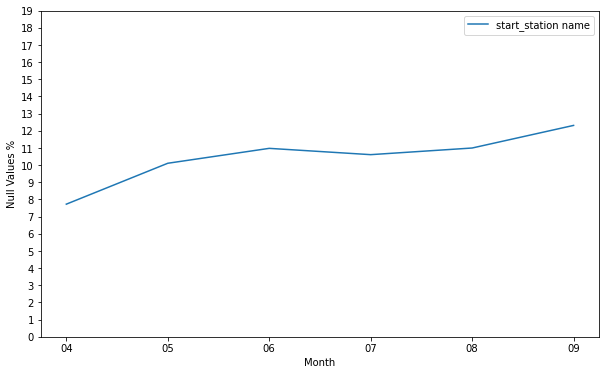

In [25]:
# Calculating the percentage of null values in station_name columns for each month
df_start_null = [(df_from_each_file[month]['start_station_name'].isna().sum()/len(df_from_each_file[month]))*100 for month in range(6)]

# Plotting
plt.figure(figsize=(10,6))
month = ['04', '05', '06', '07', '08', '09']
plt.plot(month, df_start_null, label='start_station name')
plt.xlabel('Month')
plt.yticks(range(0,20))
plt.ylabel('Null Values %')
plt.legend()
plt.show()

Null values in the column vary from 8% to %13 for each month. It doesn't seem like all null values coming from a certain month.

I will simply drop those null values.

In [ ]:
df.dropna(inplace=True)

### Removing Outliers
- ride_duration and distance columns are skewed and not normally distributed. I will simply remove outliers using 0.001 and 0.999 percentiles.

In [ ]:
# removing outliers in 'distance' column
min_threshold, max_threshold = df.distance.quantile([0.001, 0.999])
df = df[(df.distance>min_threshold) & (df.distance<max_threshold)]

In [ ]:
# removing outliers in 'ride_duration' column
min_threshold, max_threshold = df.ride_duration.quantile([0.001, 0.999])
df = df[(df.ride_duration>min_threshold) & (df.ride_duration<max_threshold)]

In [21]:
df.reset_index(drop=True, inplace=True)

In [22]:
df.shape

(3723394, 12)

In [27]:
df.head()

,ride_id,rideable_type,start_station_name,start_lat,start_lng,member_casual,hour,dayofweek,month,ride_duration,distance,same_location
0,6C992BD37A98A63F,classic_bike,State St & Pearson St,41.897448,-87.628722,member,18,Monday,April,31.32,6.35,0
1,1887262AD101C604,classic_bike,Honore St & Division St,41.903119,-87.673935,member,9,Saturday,April,25.10,5.08,0
2,097E76F3651B1AC1,classic_bike,Clinton St & Polk St,41.871467,-87.640949,casual,18,Sunday,April,0.68,0.00,1
3,53C38EB01E6FA5C4,classic_bike,Ashland Ave & 63rd St,41.779374,-87.664843,casual,16,Saturday,April,1.43,0.00,1
4,D53AC014EFD6E2BA,electric_bike,Dorchester Ave & 49th St,41.805832,-87.592478,casual,16,Tuesday,April,25.83,0.02,1


In [26]:
df.to_csv('cleaned_data.csv',index=False)